In [36]:
import pandas as pd
import os 
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
import string
from nltk.corpus import stopwords

In [2]:
Path = "../sample/mercari-price-suggestion-challenge/train.tsv"
train = pd.read_csv(f'train.tsv', sep='\t')
test = pd.read_csv(f'test.tsv' , sep= '\t')
print(train.columns)
print(train.dtypes,end = "\n\n")
print("train shape = ", end = " ")
print(train.shape)    #(1482535, 8)
print("test shape = " , end = " ")
print(test.shape) #(693359, 7)  //price missing
temp = train

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description'],
      dtype='object')
train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

train shape =  (1482535, 8)
test shape =  (693359, 7)


In [3]:
temp['price'] = train['price']*71.04  #I need in rupees not dollor
train['price'] = temp['price']
train.head(20)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,710.40,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3694.08,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,710.40,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,2486.40,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,3125.76,0,Complete with certificate of authenticity
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,4191.36,0,"Banana republic bottoms, Candies skirt with ma..."
6,6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,4546.56,0,Size small but straps slightly shortened to fi...
7,7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,426.24,1,You get three pairs of Sophie cheer shorts siz...
8,8,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,Nike,1349.76,0,Girls Size small Plus green. Three shorts total.
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,NaN,568.32,0,I realized his pants are on backwards after th...


In [4]:
train.price.describe()  
#it's largly inclined towards expensive items than cheap items 

count    1.482535e+06
mean     1.899433e+03
std      2.741154e+03
min      0.000000e+00
25%      7.104000e+02
50%      1.207680e+03
75%      2.060160e+03
max      1.427194e+05
Name: price, dtype: float64

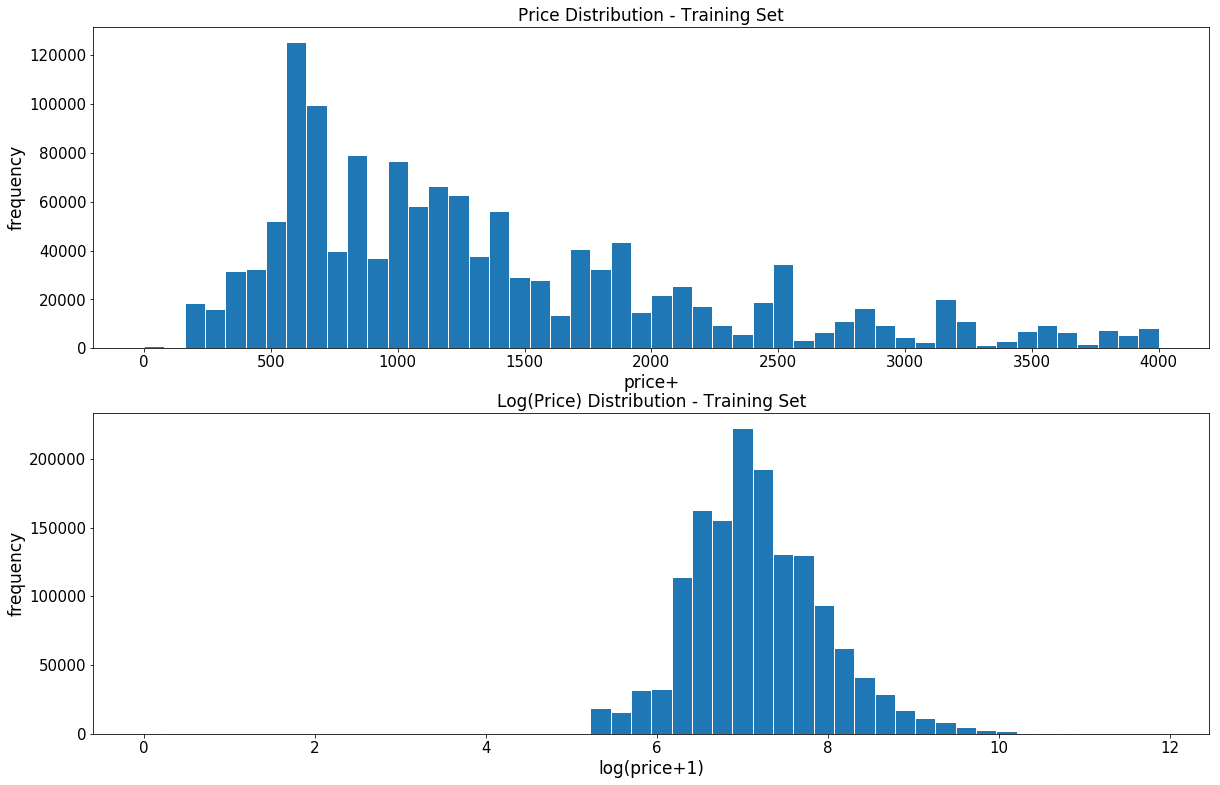

In [5]:
#as price was largly inclined towards expensive items we will take log(price) for uniform distribution
#here is a comparision of how exactly will they differ

plt.subplot(2, 1, 1)
(train['price']).plot.hist(bins=50, figsize=(20,13), edgecolor='white',range=[0,4000])
plt.xlabel('price+', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Price Distribution - Training Set', fontsize=17)

plt.subplot(2, 1, 2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(20,13), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Log(Price) Distribution - Training Set', fontsize=17)
plt.show()

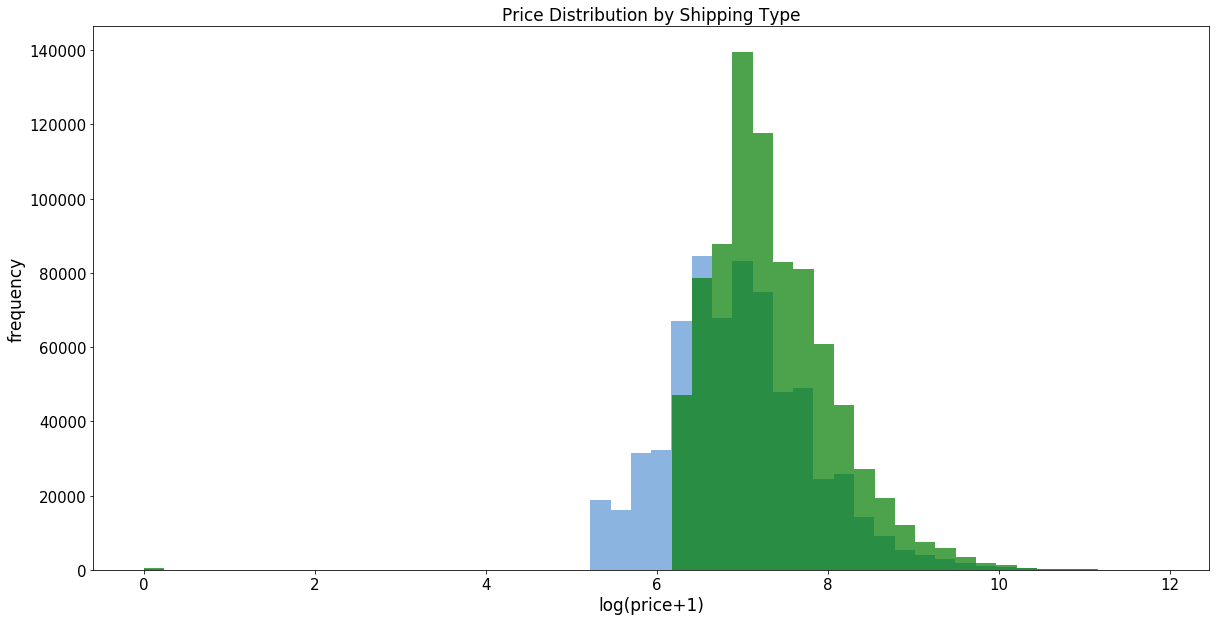

In [6]:
prc_shipBySeller = train.loc[train.shipping==1, 'price']

prc_shipByBuyer = train.loc[train.shipping==0, 'price']
#print(prc_shipByBuyer)

fig, ax = plt.subplots(figsize=(20,10))
ax.hist(np.log(prc_shipBySeller+1), color='#8CB4E1', alpha=1.0, bins=50,
       label='Price when Seller pays Shipping')
ax.hist(np.log(prc_shipByBuyer+1), color='#007D00', alpha=0.7, bins=50,
       label='Price when Buyer pays Shipping')
ax.set(title='Histogram Comparison', ylabel='% of Dataset in Bin')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.title('Price Distribution by Shipping Type', fontsize=17)
plt.tick_params(labelsize=15)  #size of 
plt.show()

In [7]:
np.sum(train['category_name'].isnull()) #items without category

6327

In [8]:
#test of iloc
mydict = [ {'a': 1, 'b': 2, 'c': 3, 'd': 4},{'a': 100, 'b': 200, 'c': 300, 'd': 400},{'a': 1000, 'b': 2000, 'c': 3000, 'd': 4000 }]
df = pd.DataFrame(mydict)
print(df)
df.iloc[1, 0]

      a     b     c     d
0     1     2     3     4
1   100   200   300   400
2  1000  2000  3000  4000


100

In [9]:
#category is 3rd index
#we'll use df.iloc to access specific rows
# train['general_category'] = "No Label"
# train['subc1'] = "No Label"
# train['subc2'] = "No Label"

# for x in range(len(temp.index)):
#     #print(x)
#     if temp.iloc[x-1,3] != None:
#         #temp2 = re.findall("\*",temp.iloc[x-1,3])
#         temp3 = temp.iloc[x-1,3].split('/',3)
#         #print(temp3)
#         if(len(temp3) == 1 | len(temp3) == 2):
#             print("yes here it is")
#         temp.iloc[x-1,8] = temp3[0]  
#         temp.iloc[x-1,9] = temp3[1]
#         temp.iloc[x-1,10]  = temp3[2]
        
        
#so i was trying to split category into 3 parts but my code isn't working 

In [10]:
#Now doing the same stuff as did above except via a copied code
def splitit(text):
    try: return text.split("/")
    except: return ("No Label" , "No Label" , "No Label")

train['general_cat'], train['subcat_1'], train['subcat_2'] = \
zip(*train['category_name'].apply(lambda x: splitit(x)))
train.head()
    

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,710.40,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3694.08,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,710.40,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,2486.40,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,3125.76,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [11]:
x = train['general_cat'].value_counts().index.values.astype('str')
y = train['general_cat'].value_counts().values
pct = [("%.2f"%(v*100))+"%"for v in (y/len(train))]   

print(x)  #tags
print(y)  #no of tags
print(pct)  #% of tags 

['Women' 'Beauty' 'Kids' 'Electronics' 'Men' 'Home'
 'Vintage & Collectibles' 'Other' 'Handmade' 'Sports & Outdoors'
 'No Label']
[664385 207828 171689 122690  93680  67871  46530  45351  30842  25342
   6327]
['44.81%', '14.02%', '11.58%', '8.28%', '6.32%', '4.58%', '3.14%', '3.06%', '2.08%', '1.71%', '0.43%']


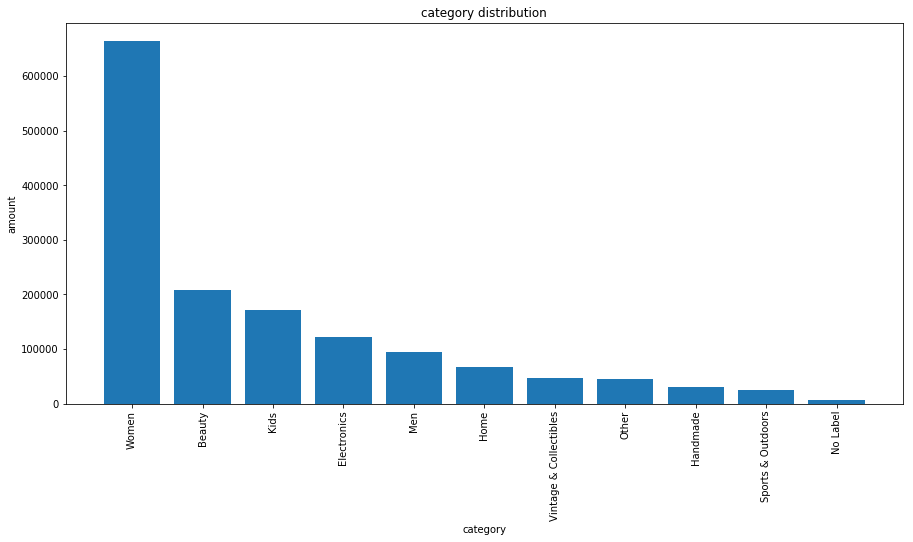

In [12]:
#plotting the same thing as in the previous cell

index = np.arange(len(x))
plt.figure(figsize=(15,7))
plt.bar(index,y)
plt.xlabel('category' , fontsize = 10)
plt.ylabel('amount',fontsize = 10)
plt.xticks(index,x,fontsize = 10 , rotation =90)
plt.title('category distribution')

plt.show()

In [13]:
print(train['brand_name'].nunique()) 
#that is 4809 unique brands

4809


In [48]:

def check_effective_length(text):
        final_word = [word for word in nltk.word_tokenize(text) if word not in string.punctuation and \
                      word not in stopwords.words('english') and \
                      len(word)>2]
        return len(final_word)



In [50]:
train["desc_len"] = train["item_description"].apply(lambda x :check_effective_length(x))
test["desc_len"]  = test["item_description"].apply(lambda x :check_effective_length(x))
train.head(5)
#takes a lot of time to execute

KeyboardInterrupt: 

In [51]:

df = train.groupby('desc_len')['price'].mean().reset_index()
trace1 = go.Scatter(
    x = df['desc_len'],
    y = np.log(df['price']+1),
    mode = 'lines+markers',
    name = 'lines+markers'
)
layout = dict(title= 'Average Log(Price) by Description Length',
              yaxis = dict(title='Average Log(Price)'),
              xaxis = dict(title='Description Length'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

NameError: name 'go' is not defined

In [57]:
print(train.item_description.isnull().sum())
train = train[pd.notnull(train['item_description'])]

4
